In [12]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from helper_functions import plot_anomaly_data

**Problem Statement**

You run a company that deals with server maintenance, therefore, you need to implement an anomaly detection algorithm to detect anomalous behavior in server computers. You have access to the following data:

   * Throughput (mb/s) of each server.
   * Latency (ms) of response of each server.

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. You will use a Gaussian model to detect anomalous examples in your dataset. 

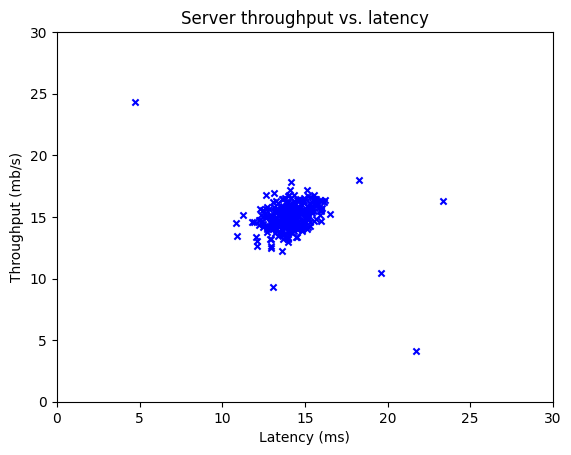

In [13]:
# Load the dataset
X_train = np.load("data/anomaly_detection1.npy")
X_val = np.load("data/anomaly_detection2.npy")
y_val = np.load("data/anomaly_detection3.npy")

assert X_train.shape == (307, 2)
assert X_val.shape == (307, 2)
assert y_val.shape == (307,)
plot_anomaly_data(X_train, "Server throughput vs. latency")

First, we need to implement the `estimate_gaussian` function to calculate `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`) using the following formulas:

$$
\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}
\qquad\qquad\qquad\qquad
\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2
$$

In [14]:
def estimate_gaussian(X: ndarray) -> tuple[ndarray, ndarray]:
    """
    Calculates mean and variance of all features in the dataset.

    Args:
        X (ndarray): (m, n) Data matrix.

    Returns:
        mu (ndarray): (n,) Mean of all features.
        var (ndarray): (n,) Variance of all features.
    """
    m = X.shape[0]
    mu = np.sum(X, axis=0) / m
    var = np.sum((X - mu) ** 2, axis=0) / m
    return mu, var

X = np.array([[1, 2, 3], [2, 4, 6], [3, 6, 9]]).T
mu, var = estimate_gaussian(X)
assert np.allclose(mu, [2., 4., 6.], atol=0.2)
assert np.allclose(var, [2. / 3, 8. / 3., 18. / 3.], atol=0.2)

Now, we need to create a function `probability_density_function` to compute the probability density for all examples in `X`.

In [15]:
def probability_density_function(
    X: ndarray, mu: ndarray, var: ndarray
) -> ndarray:
    """
    Computes the probability density function (PDF) of given data points under
    the multivariate Gaussian distribution characterized by mean `mu` and
    variance `var`.

    Args:
        X (ndarray): (m, n) Data matrix.
        mu (ndarray): (n,) Mean of all features.
        var (ndarray): (n,) Variance of all features.

    Returns:
        ndarray: (m,) Probability density of all examples.
    """
    k = len(mu)

    if var.ndim == 1:
        var = np.diag(var)

    X = X - mu
    p = (2* np.pi) ** (-k/2)
    p *= np.linalg.det(var)**(-0.5)
    p *= np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    return p

Let's visualize the PDF in a graph:

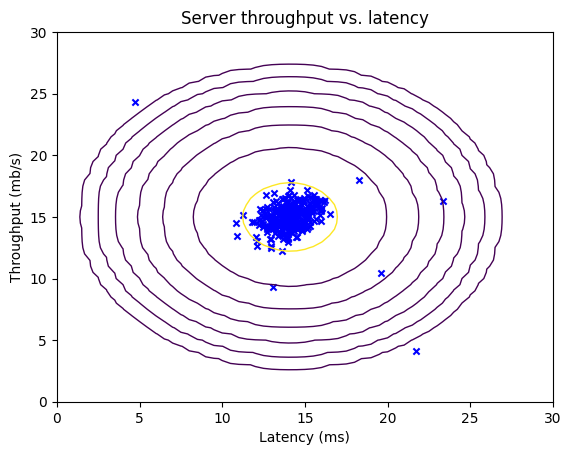

In [16]:
mu, var = estimate_gaussian(X_train)
plot_anomaly_data(
    X_train, "Server throughput vs. latency",
    probability_density_function, mu, var)

Now, we need to create the `select_threshold` function to find the best threshold $\varepsilon$ to use for selecting outliers based on the results from the validation set (`p_val`) and the ground truth (`y_val`). 

In [17]:
def select_threshold(y_val: ndarray, p_val: ndarray) -> tuple[float]:
    """
    Finds the best threshold to use for selecting outliers
    based on the results from a validation set (p_val)
    and the ground truth (y_val).

    Args:
        y_val (ndarray): Ground truth on validation set.
        p_val (ndarray): Results on validation set.

    Returns:
        epsilon (float): Threshold chosen.
        F1 (float): F1 score by choosing epsilon as threshold.
    """
    m = y_val.shape[0]
    best_epsilon = 0
    best_F1 = 0
    F1 = 0

    step_size = (max(p_val) - min(p_val)) / 1000

    for epsilon in np.arange(min(p_val), max(p_val), step_size):
        predictions = (p_val < epsilon).astype(int)

        TP = sum((predictions == 1) & (y_val == 1))
        FP = sum((predictions == 1) & (y_val == 0))
        FN = sum((predictions == 0) & (y_val == 1))

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F1 = 2 * precision * recall / (precision + recall)

        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    return best_epsilon, best_F1

p_val_test = np.array([i / 1000 for i in range(50)])
y_val_test = np.array([1] * 8 + [0] * 42)
y_val_test[5] = 0
best_epsilon, best_F1 = select_threshold(y_val_test, p_val_test)
assert np.isclose(best_epsilon, 0.007, atol=0.05 / 1000)
assert np.isclose(best_F1, 0.933333333)

/tmp/ipykernel_453815/415827248.py:29: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


Plot the outliers.

/tmp/ipykernel_453815/415827248.py:29: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


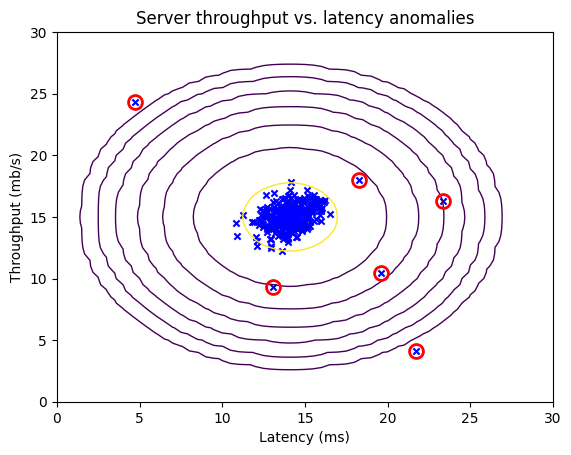

In [18]:
# Find the outliers in the training set
p = probability_density_function(X_train, mu, var)
epsilon, _ = select_threshold(y_val, p)
anomalies = p < epsilon

# Plot
plot_anomaly_data(
    X_train, f"Server throughput vs. latency anomalies",
    probability_density_function, mu, var, anomalies)